<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/Sparse%20AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3664 - val_loss: 0.2407
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2353 - val_loss: 0.2103
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2047 - val_loss: 0.1856
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1812 - val_loss: 0.1731
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1714 - val_loss: 0.1657
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Esparsidade global (|z|<0.001): 0.826
Esparsidade por neurônio (primeiros 10): [1.    1.    1.    0.086 0.058 0.04  1.    1.    1.    1.   ]


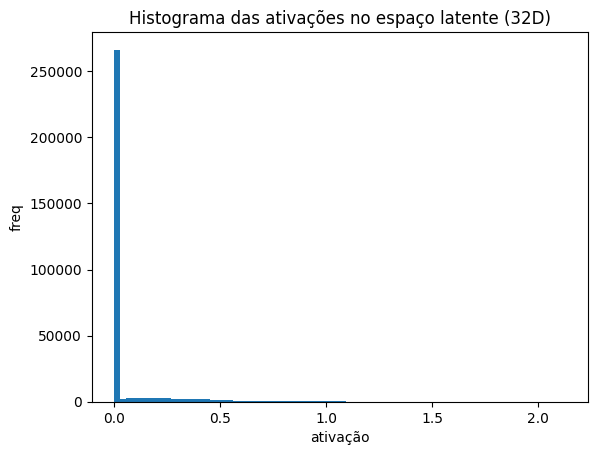

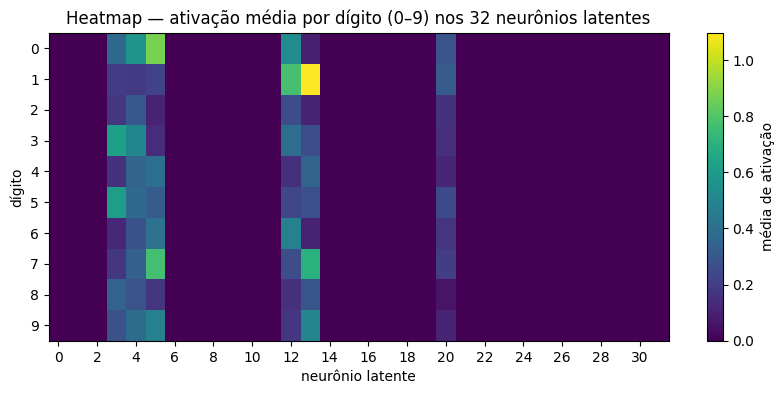

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt

# 1) Dados
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32")/255.).reshape(-1, 28*28)
x_test  = (x_test.astype("float32")/255.).reshape(-1, 28*28)

# 2) Modelo: AE com penalização L1 nas ATIVAÇÕES do bottleneck (sparse)
inp = layers.Input(shape=(784,))
h1  = layers.Dense(256, activation="relu")(inp)
h2  = layers.Dense(128, activation="relu")(h1)
z   = layers.Dense(32, activation="relu",
                   activity_regularizer=regularizers.L1(1e-5))(h2)  # <- esparsidade
d1  = layers.Dense(128, activation="relu")(z)
d2  = layers.Dense(256, activation="relu")(d1)
out = layers.Dense(784, activation="sigmoid")(d2)

autoenc = models.Model(inp, out, name="sparse_autoencoder")
autoenc.compile(optimizer="adam", loss="binary_crossentropy")
autoenc.fit(x_train, x_train, epochs=5, batch_size=256,
            shuffle=True, validation_data=(x_test, x_test), verbose=1)

# 3) Encoder para extrair o latente z
encoder = models.Model(inp, z)
Z = encoder.predict(x_test, batch_size=512)  # (N_test, 32)

# 4) Métricas simples de esparsidade
thr = 1e-3
frac_zeros_global = (np.abs(Z) < thr).mean()
frac_zeros_por_neuronio = (np.abs(Z) < thr).mean(axis=0)

print(f"Esparsidade global (|z|<{thr}): {frac_zeros_global:.3f}")
print("Esparsidade por neurônio (primeiros 10):",
      np.round(frac_zeros_por_neuronio[:10], 3))

# 5a) Histograma das ativações latentes (mostra concentração perto de 0)
plt.figure()
plt.hist(Z.flatten(), bins=80)
plt.title("Histograma das ativações no espaço latente (32D)")
plt.xlabel("ativação"); plt.ylabel("freq")
plt.show()

# 5b) Heatmap: média de ativação por dígito (10 x 32)
means_by_digit = np.zeros((10, Z.shape[1]))
for d in range(10):
    means_by_digit[d] = Z[y_test==d].mean(axis=0)

plt.figure(figsize=(10, 4))
plt.imshow(means_by_digit, aspect="auto")
plt.colorbar(label="média de ativação")
plt.yticks(range(10), [str(i) for i in range(10)])
plt.xticks(range(0, Z.shape[1], 2))
plt.title("Heatmap — ativação média por dígito (0–9) nos 32 neurônios latentes")
plt.xlabel("neurônio latente"); plt.ylabel("dígito")
plt.show()
